<div style="float: right; color: red;">Please, rename this file to <code style="color:red">HW6.ipynb</code> and save it in <code style="color:red">MSA8010F16/HW6</code>
</div>

# Homework 6: Preprocessing Data
We use a data set from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing 
to experiment with a Decision Tree classifier http://www.saedsayad.com/decision_tree.htm

Scikit-Learn: http://scikit-learn.org/stable/modules/tree.html#tree

Book slides:
- http://131.96.197.204/~pmolnar/mlbook/BookSlides_4A_Information-based_Learning.pdf
- http://131.96.197.204/~pmolnar/mlbook/BookSlides_4B_Information-based_Learning.pdf



### Bank Marketing Data Set 
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


Attribute Information:

Input variables:
- *bank client data:*
        1 age (numeric)
        2 job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
        3 marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
        4 education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
        5 default: has credit in default? (categorical: 'no','yes','unknown')
        6 housing: has housing loan? (categorical: 'no','yes','unknown')
        7 loan: has personal loan? (categorical: 'no','yes','unknown')
- *related with the last contact of the current campaign:*
        8 contact: contact communication type (categorical: 'cellular','telephone') 
        9 month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
        10 day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
        11 duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- *other attributes:*
        12 campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        13 pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
        14 previous: number of contacts performed before this campaign and for this client (numeric)
        15 poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- *social and economic context attributes*
        16 emp.var.rate: employment variation rate - quarterly indicator (numeric)
        17 cons.price.idx: consumer price index - monthly indicator (numeric) 
        18 cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
        19 euribor3m: euribor 3 month rate - daily indicator (numeric)
        20 nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
    21 y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATAFILE = '/home/data/archive.ics.uci.edu/BankMarketing/bank.csv'
###DATAFILE = 'data/bank.csv'  ### using locally

In [3]:
df = pd.read_csv(DATAFILE, sep=';')
list(df.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

## Step 1: Investigate Data Set
- We have a number of categorical data: What's their cardinality? How are the levels distributed?
- What's the distribution on numeric values? Do we see any correlations?

Let's first look at columns (i.e. variables) with continuous values. We can get a sense of the distribution from aggregate functions like mean, standard variation, quantiles, as well as, minimum and maximum values.

The Pandas method `describe` creates a table view of those metrics. (The methods can also be used to identify numeric features in the data frame.

In [4]:
### use sets and '-' difference operation 'A-B'. Also there is a symmetric different '^'
all_features = set(df.columns)-set(['y'])
num_features = set(df.describe().columns)
cat_features = all_features-num_features

print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          day, balance, poutcome, month, pdays, housing, duration, education, default, loan, marital, previous, contact, job, campaign, age 
Numerical features:    pdays, duration, day, balance, previous, campaign, age 
Categorical features:  month, housing, education, default, loan, marital, poutcome, contact, job


In [21]:
### Describe Columns
help(pd.DataFrame.describe)

Help on function describe in module pandas.core.generic:

describe(self, percentiles=None, include=None, exclude=None)
    Generate various summary statistics, excluding NaN values.
    
    Parameters
    ----------
    percentiles : array-like, optional
        The percentiles to include in the output. Should all
        be in the interval [0, 1]. By default `percentiles` is
        [.25, .5, .75], returning the 25th, 50th, and 75th percentiles.
    include, exclude : list-like, 'all', or None (default)
        Specify the form of the returned result. Either:
    
        - None to both (default). The result will include only
          numeric-typed columns or, if none are, only categorical columns.
        - A list of dtypes or strings to be included/excluded.
          To select all numeric types use numpy numpy.number. To select
          categorical objects use type object. See also the select_dtypes
          documentation. eg. df.describe(include=['O'])
        - If include is 

In [226]:
### Let's get the description of the numeric data for each of the target values separately.
### We need to rename the columns before we can properly join the tables. The column names may look strange...
desc_yes = df[df.y=='yes'].describe().rename_axis(lambda c: "%s|A"%c, axis='columns')
desc_no  = df[df.y=='no'].describe().rename_axis(lambda c: "%s|B"%c, axis='columns')
### ...but this way we can get them in the desired order...
desc = desc_yes.join(desc_no).reindex_axis(sorted(desc.columns), axis=1)
### ...because we're changing them anyway:
desc.set_axis(1, [sorted(list(num_features)*2), ['yes', 'no']*len(num_features)])
desc

age                    balance                  campaign  \
              yes           no           yes            no         yes   
count  521.000000  4000.000000    521.000000   4000.000000  521.000000   
mean    42.491363    40.998000   1571.955854   1403.211750    2.266795   
std     13.115772    10.188398   2444.398956   3075.349313    2.092071   
min     19.000000    19.000000  -1206.000000  -3313.000000    1.000000   
25%     32.000000    33.000000    171.000000     61.000000    1.000000   
50%     40.000000    39.000000    710.000000    419.500000    2.000000   
75%     50.000000    48.000000   2160.000000   1407.000000    3.000000   
max     87.000000    86.000000  26965.000000  71188.000000   24.000000   

                           day                  duration               \
                no         yes           no          yes           no   
count  4000.000000  521.000000  4000.000000   521.000000  4000.000000   
mean      2.862250   15.658349    15.948750   552.742802   226.347500   
std       3.212609    8.235148     8.249736   390.325805   210.313631   
min       1.000000    1.000000     1.000000    30.000000     4.000000   
25%       1.000000    9.000000     8.000000   260.000000    96.000000   
50%       2.000000   15.000000    16.000000   442.000000   167.000000   
75%       3.000000   22.000000    21.000000   755.000000   283.000000   
max      50.000000   31.000000    31.000000  2769.000000  3025.000000   

            pdays                 previous               
              yes           no         yes           no  
count  521.000000  4000.000000  521.000000  4000.000000  
mean    68.639155    36.006000    1.090211     0.471250  
std    121.963063    96.297657    2.055368     1.627371  
min     -1.000000    -1.000000    0.000000     0.000000  
25%     -1.000000    -1.000000    0.000000     0.000000  
50%     -1.000000    -1.000000    0.000000     0.000000  
75%     98.000000    -1.000000    2.000000     0.000000  
max    804.000000   871.000000   14.000000    25.000000

Let's look at the distribution of numerical features...

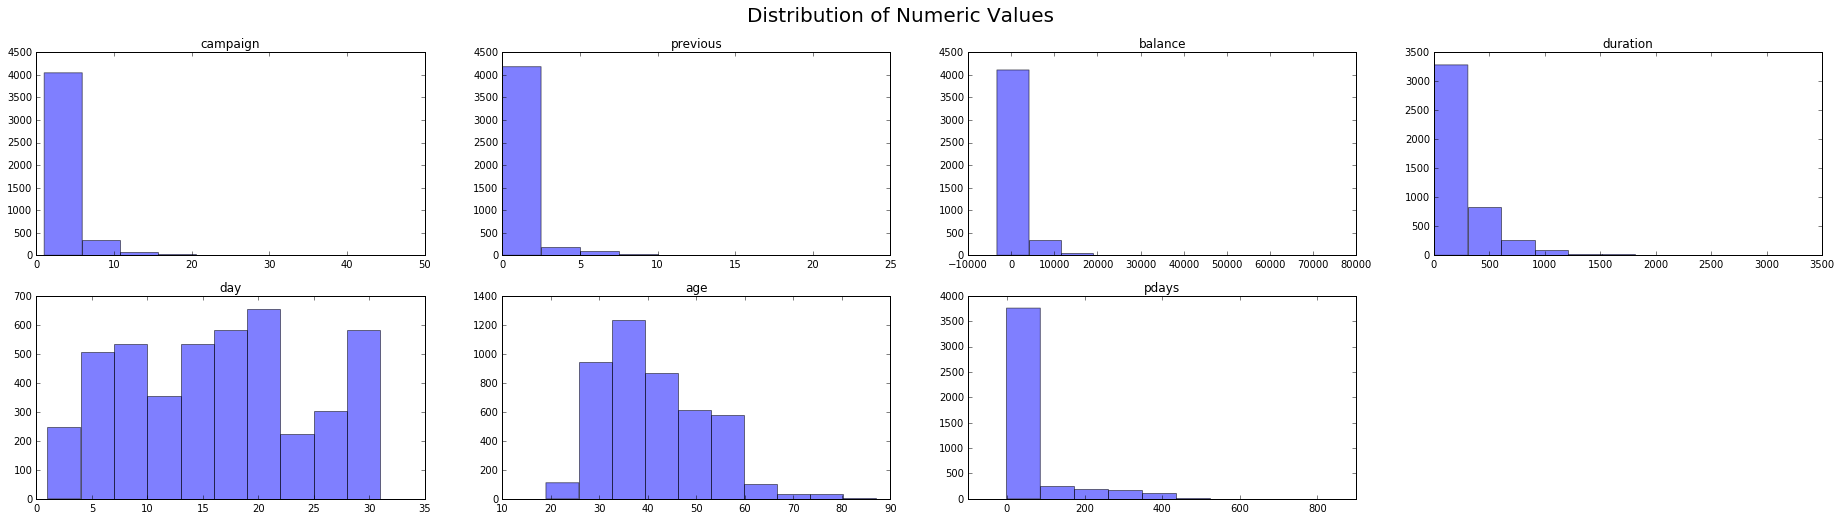

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(32, 8))
for i in range(len(num_features)):
    f = list(num_features)[i]
    plt.subplot(2, 4, i+1)
    hst = plt.hist(df[f], alpha=0.5)
    plt.title(f)
plt.suptitle('Distribution of Numeric Values', fontsize=20)
None

Now, let's look at the categorical variables and their distribution...

In [65]:
for f in cat_features:
    tab = df[f].value_counts()
    print('%s:\t%s' % (f, ', '.join([ ("%s(%d)" %(tab.index[i], tab.values[i])) for i in range(len(tab))]) ))

education:	secondary(2306), tertiary(1350), primary(678), unknown(187)
default:	no(4445), yes(76)
job:	management(969), blue-collar(946), technician(768), admin.(478), services(417), retired(230), self-employed(183), entrepreneur(168), unemployed(128), housemaid(112), student(84), unknown(38)
month:	may(1398), jul(706), aug(633), jun(531), nov(389), apr(293), feb(222), jan(148), oct(80), sep(52), mar(49), dec(20)
poutcome:	unknown(3705), failure(490), other(197), success(129)
loan:	no(3830), yes(691)
housing:	yes(2559), no(1962)
marital:	married(2797), single(1196), divorced(528)
contact:	cellular(2896), unknown(1324), telephone(301)


Results in a data frame:

In [107]:
mat = pd.DataFrame(
    [ df[f].value_counts() for f in list(cat_features) ],
    index=list(cat_features)
    ).stack()

pd.DataFrame(mat.values, index=mat.index)

0
education primary         678.0
          secondary      2306.0
          tertiary       1350.0
          unknown         187.0
default   no             4445.0
          yes              76.0
job       admin.          478.0
          blue-collar     946.0
          entrepreneur    168.0
          housemaid       112.0
          management      969.0
          retired         230.0
          self-employed   183.0
          services        417.0
          student          84.0
          technician      768.0
          unemployed      128.0
          unknown          38.0
month     apr             293.0
          aug             633.0
          dec              20.0
          feb             222.0
          jan             148.0
          jul             706.0
          jun             531.0
          mar              49.0
          may            1398.0
          nov             389.0
          oct              80.0
          sep              52.0
poutcome  failure         490.0
          other           197.0
          success         129.0
          unknown        3705.0
loan      no             3830.0
          yes             691.0
housing   no             1962.0
          yes            2559.0
marital   divorced        528.0
          married        2797.0
          single         1196.0
contact   cellular       2896.0
          telephone       301.0
          unknown        1324.0

## Step 2: Prepare for ML algorithm
The ML algorithms in Scikit-Learn use Matrices (with numeric values). We need to convert our data-frame into a feature matrix `X` and a target vector `y`.
Many algorithms also require the features to be in the same range. Decision-trees don't bother because they don't perform any operations across features.

Use the `pd.DataFrame.as_matrix` method to convert a DataFrame into a matrix.

In [10]:
help(pd.DataFrame.as_matrix)

In [110]:
## We copy our original dataframe into a new one, and then perform replacements on categorical levels.
## We may also keep track of our replacement
level_substitution = {}

def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = df.copy()

for c in cat_features:
    level_substitution[c] = levels2index(df[c].unique())
    df_num[c].replace(level_substitution[c], inplace=True)

## same for target
df_num.y.replace({'no':0, 'yes':1}, inplace=True)

df_num

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,0,0,0,1787,0,0,0,19,0,79,1,-1,0,0,0
1,33,1,0,1,0,4789,1,1,0,11,1,220,1,339,4,1,0
2,35,2,1,2,0,1350,1,0,0,16,2,185,1,330,1,1,0
3,30,2,0,2,0,1476,1,1,1,3,3,199,4,-1,0,0,0
4,59,3,0,1,0,0,1,0,1,5,1,226,1,-1,0,0,0
5,35,2,1,2,0,747,0,0,0,23,4,141,2,176,3,1,0
6,36,4,0,2,0,307,1,0,0,14,1,341,1,330,2,2,0
7,39,5,0,1,0,147,1,0,0,6,1,151,2,-1,0,0,0
8,41,6,0,2,0,221,1,0,1,14,1,57,2,-1,0,0,0
9,43,1,0,0,0,-88,1,1,0,17,2,313,1,147,2,1,0


In [9]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

## Step 3: Training
Now that we have our DataFrame prepared, we can create the feature matrix `X` and target vector `y`:
1. split data into **training** and **test** sets
2. fit the model

In [114]:
X = df_num[list(all_features)].as_matrix()
y = df_num.y.as_matrix()
X, y

(array([[   0,    0,    0, ...,    0, 1787,    0],
        [   1,    0,    1, ...,    1, 4789,    1],
        [   2,    0,    2, ...,    2, 1350,    0],
        ..., 
        [   1,    0,    5, ...,    5,  295,    0],
        [   1,    0,    3, ...,    4, 1137,    0],
        [   2,    0,    6, ...,    2, 1136,    1]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [115]:
### Scikit-learn provides us with a nice function to split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [116]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)

In [154]:
clf.fit(X_train, y_train)
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print('Ratio of correctly classified samples for:\n\tTraining-set:\t%f\n\tTest-set:\t%f'%(score_train, score_test))

Ratio of correctly classified samples for:
	Training-set:	0.913717
	Test-set:	0.903261


`score` returns the mean accuracy on the given test data and labels. In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted. For binary classification it means **percentage of correctly classified samples**.
The score should be close to 1. Though, one single number does not tell the whole story...

## Step 4: Evaluate Model
1. predict $\hat y$ for your model on **test set**
2. calculate confusion matrix and derive measures
3. visualize if suitable

Let's see what we got. We can actually print the entire decision tree and trace for each sample ... though you may need to use the viz-wall for that.

In [1]:
import sklearn.tree
import pydot_ng as pdot
dot_data = sklearn.tree.export_graphviz(clf, out_file=None, feature_names = list(all_features), class_names=['no', 'yes'])
graph = pdot.graph_from_dot_data(dot_data)
#--- we can save the graph into a file ... preferrably vector graphics
#graph.write_svg('mydt.svg')
#graph.write_pdf('mydt.pdf')

#--- or display right here 
from IPython.display import HTML
HTML(str(graph.create_svg().decode('utf-8')))

NameError: name 'clf' is not defined

Now, we use out classifier and predict on the test set (In order to get the `ŷ` character type: 'y\hat' followed by the TAB-key.) 

In [166]:
ŷ = clf.predict(X_test)

In [168]:
## a function that produces the confusion matrix: 1. parameter y=actual target, 2. parameter ŷ=predicted
def binary_confusion_matrix(y,ŷ):
    TP = ((y+ŷ)== 2).sum()
    TN = ((y+ŷ)== 0).sum()
    FP = ((y-ŷ)== -1).sum()
    FN = ((y-ŷ)== 1).sum()
    return pd.DataFrame( [[TP, FP], [FN, TN]], index=[['Prediction', 'Prediction'],['Yes', 'No']], columns=[['Actual', 'Actual'],['Yes', 'No']])

cm = binary_confusion_matrix(y_test, ŷ)
cm

Actual      
                  Yes    No
Prediction Yes     73    59
           No     116  1561

In [176]:
### Scikit-Learn can do that too ... so so nice though
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ŷ)
cm

array([[1561,   59],
       [ 116,   73]])

In [172]:
### Here are some metrics 
from sklearn.metrics import classification_report
print(classification_report(y_test, ŷ))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95      1620
          1       0.55      0.39      0.45       189

avg / total       0.89      0.90      0.90      1809



In [181]:
### http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
np.set_printoptions(precision=2)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.96  0.04]
 [ 0.61  0.39]]


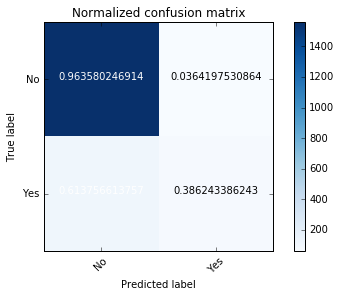

In [182]:
%matplotlib inline

fig = plt.figure()
plot_confusion_matrix(cm, classes=['No', 'Yes'], normalize=True, title='Normalized confusion matrix')
plt.show()

## Step 5: Figure out how to improve and go back to Step 2 or 3
This is an experiement. What can we change to improve the performance of the model?
- Include or exclude certain features
- Scale or transform values of feature vectors
- Identify outliers (noise) and remove them
- Adjust parameters of the ML algorithm 

### Defining and investigating data
I'm going to use the full dataset, and want to repeat some of the investigation on it. I'm removing the "Duration" attribute because of the recommendation in the data set's notes (it "should be discarded if the intention is to have a realistic predictive model").

In [3]:
FULLDATAFILE = '/home/data/archive.ics.uci.edu/BankMarketing/bank-full.csv'
df2 = pd.read_csv(FULLDATAFILE, sep=';')
df2.drop('duration', axis=1, inplace=True)
list(df2.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [4]:
all_features = set(df2.columns)-set(['y'])
num_features = set(df2.describe().columns)
cat_features = all_features-num_features

print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          education, age, previous, month, default, day, job, poutcome, marital, loan, contact, balance, pdays, housing, campaign 
Numerical features:    age, previous, balance, pdays, day, campaign 
Categorical features:  education, poutcome, marital, loan, contact, housing, month, default, job


In [5]:
desc_yes = df2[df2.y=='yes'].describe().rename_axis(lambda c: "%s|A"%c, axis='columns')
desc_no  = df2[df2.y=='no'].describe().rename_axis(lambda c: "%s|B"%c, axis='columns')
desc = desc_yes.join(desc_no)
desc = desc.reindex_axis(sorted(desc.columns), axis=1)
desc.set_axis(1, [sorted(list(num_features)*2), ['yes', 'no']*len(num_features)])
desc

age                     balance                    campaign  \
               yes            no           yes             no          yes   
count  5289.000000  39922.000000   5289.000000   39922.000000  5289.000000   
mean     41.670070     40.838986   1804.267915    1303.714969     2.141047   
std      13.497781     10.172662   3501.104777    2974.195473     1.921826   
min      18.000000     18.000000  -3058.000000   -8019.000000     1.000000   
25%      31.000000     33.000000    210.000000      58.000000     1.000000   
50%      38.000000     39.000000    733.000000     417.000000     2.000000   
75%      50.000000     48.000000   2159.000000    1345.000000     3.000000   
max      95.000000     95.000000  81204.000000  102127.000000    32.000000   

                             day                      pdays                \
                 no          yes            no          yes            no   
count  39922.000000  5289.000000  39922.000000  5289.000000  39922.000000   
mean       2.846350    15.158253     15.892290    68.702968     36.421372   
std        3.212767     8.501875      8.294728   118.822266     96.757135   
min        1.000000     1.000000      1.000000    -1.000000     -1.000000   
25%        1.000000     8.000000      8.000000    -1.000000     -1.000000   
50%        2.000000    15.000000     16.000000    -1.000000     -1.000000   
75%        3.000000    22.000000     21.000000    98.000000     -1.000000   
max       63.000000    31.000000     31.000000   854.000000    871.000000   

          previous                
               yes            no  
count  5289.000000  39922.000000  
mean      1.170354      0.502154  
std       2.553272      2.256771  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       1.000000      0.000000  
max      58.000000    275.000000

In [41]:
print('Percent yes is ',sum(df2['y'] == 'yes')/len(df2))
print('Percent no is ',sum(df2['y'] == 'no')/len(df2))

Percent yes is  0.116984804583
Percent no is  0.883015195417


We have very imbalanced classes - the thing we want to predict, the 'yes', represent only 11% of the data.

#### It seems there may be outliers in some of the numeric columns, but it doesn't seem appropriate to define outliers the same for these different columns. I'll leave them for now.

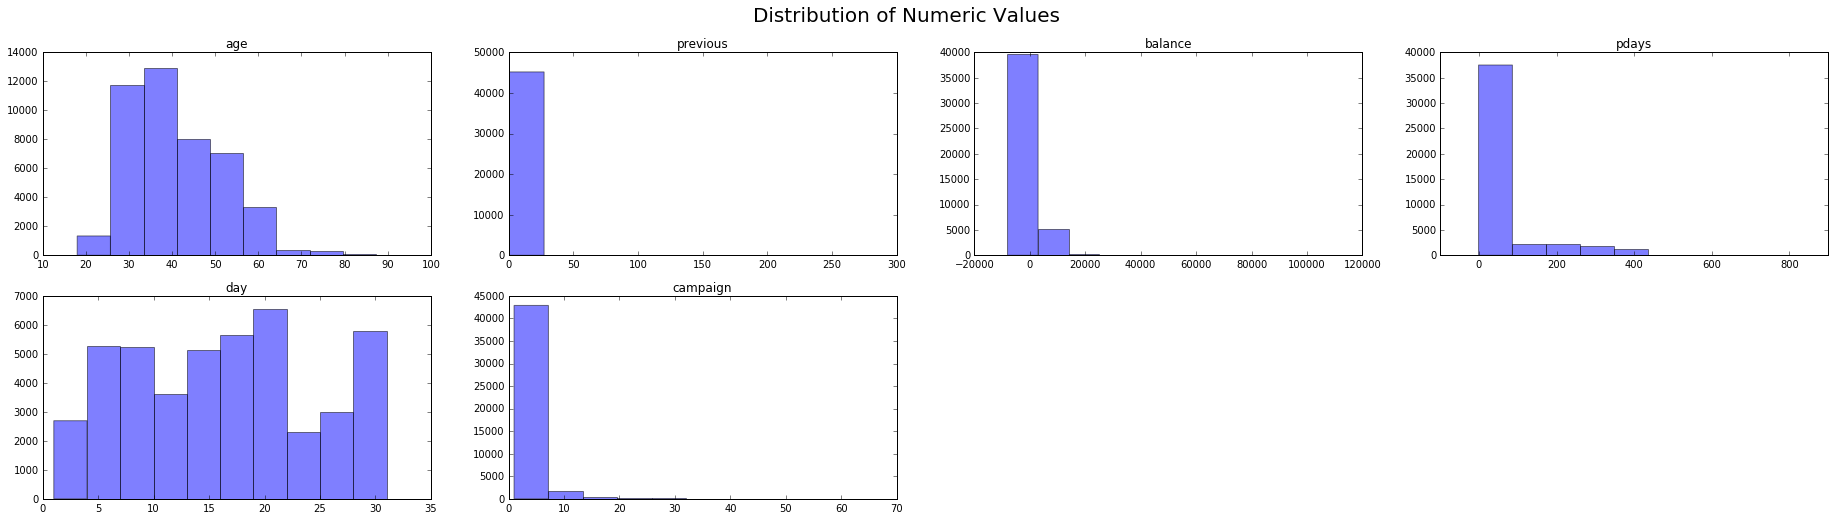

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(32, 8))
for i in range(len(num_features)):
    f = list(num_features)[i]
    plt.subplot(2, 4, i+1)
    hst = plt.hist(df2[f], alpha=0.5)
    plt.title(f)
plt.suptitle('Distribution of Numeric Values', fontsize=20)
None

In [7]:
df2.corr()

,age,balance,day,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,0.162490,-0.093044,-0.051710
campaign,0.004760,-0.014578,0.162490,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,-0.032855,0.454820,1.000000


#### This correlation matrix doesn't indicate strong correlation between any of the numeric variables except for pdays and previous, which show moderate positive correlation. This means that the more previous contacts indicates longer time between contacts. These values both seem important for this classification, so I'll leave them.

In [8]:
mat = pd.DataFrame(
    [ df2[f].value_counts() for f in list(cat_features) ],
    index=list(cat_features)
    ).stack()

pd.DataFrame(mat.values, index=mat.index)

0
education primary         6851.0
          secondary      23202.0
          tertiary       13301.0
          unknown         1857.0
poutcome  failure         4901.0
          other           1840.0
          success         1511.0
          unknown        36959.0
marital   divorced        5207.0
          married        27214.0
          single         12790.0
loan      no             37967.0
          yes             7244.0
contact   cellular       29285.0
          telephone       2906.0
          unknown        13020.0
housing   no             20081.0
          yes            25130.0
month     apr             2932.0
          aug             6247.0
          dec              214.0
          feb             2649.0
          jan             1403.0
          jul             6895.0
          jun             5341.0
          mar              477.0
          may            13766.0
          nov             3970.0
          oct              738.0
          sep              579.0
default   no             44396.0
          yes              815.0
job       admin.          5171.0
          blue-collar     9732.0
          entrepreneur    1487.0
          housemaid       1240.0
          management      9458.0
          retired         2264.0
          self-employed   1579.0
          services        4154.0
          student          938.0
          technician      7597.0
          unemployed      1303.0
          unknown          288.0

#### Because of the number of "unknown" responses in the poutcome column, it doesn't seem this would be very useful. I'm removing it.

In [9]:
df2.drop('poutcome',axis=1,inplace=True)

In [10]:
cat_features.remove('poutcome')

In [11]:
all_features.remove('poutcome')

### Prepare for ML algorithm

In [12]:
level_substitution = {}

def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = df2.copy()

for c in cat_features:
    level_substitution[c] = levels2index(df2[c].unique())
    df_num[c].replace(level_substitution[c], inplace=True)

## same for target
df_num.y.replace({'no':0, 'yes':1}, inplace=True)

df_num.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,58,0,0,0,0,2143,0,0,0,5,0,1,-1,0,0
1,44,1,1,1,0,29,0,0,0,5,0,1,-1,0,0
2,33,2,0,1,0,2,0,1,0,5,0,1,-1,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,1,-1,0,0
4,33,4,1,2,0,1,1,0,0,5,0,1,-1,0,0


### Training, again with Decision Tree model

In [13]:
X = df_num[list(all_features)].as_matrix()
y = df_num.y.as_matrix()
X, y

(array([[  0,  58,   0, ...,  -1,   0,   1],
        [  1,  44,   0, ...,  -1,   0,   1],
        [  1,  33,   0, ...,  -1,   0,   1],
        ..., 
        [  1,  72,   3, ..., 184,   1,   5],
        [  1,  57,   0, ...,  -1,   1,   4],
        [  1,  37,  11, ..., 188,   1,   2]]), array([0, 0, 0, ..., 1, 0, 0]))

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=19)

clf = DecisionTreeClassifier(max_depth=10)

In [16]:
clf.fit(X_train, y_train)
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print('Ratio of correctly classified samples for:\n\tTraining-set:\t%f\n\tTest-set:\t%f'%(score_train, score_test))

Ratio of correctly classified samples for:
	Training-set:	0.905963
	Test-set:	0.885358


### Evaluating

In [17]:
ŷ = clf.predict(X_test)

In [18]:
def binary_confusion_matrix(y,ŷ):
    TP = ((y+ŷ)== 2).sum()
    TN = ((y+ŷ)== 0).sum()
    FP = ((y-ŷ)== -1).sum()
    FN = ((y-ŷ)== 1).sum()
    return pd.DataFrame( [[TP, FP], [FN, TN]], index=[['Prediction', 'Prediction'],['Yes', 'No']], columns=[['Actual', 'Actual'],['Yes', 'No']])

cm = binary_confusion_matrix(y_test, ŷ)
cm


Actual       
                  Yes     No
Prediction Yes    332    349
           No    1206  11677

In [44]:
(332+349)/(332+349+1206+11677)

0.050206428782070184

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ŷ))

             precision    recall  f1-score   support

          0       0.91      0.97      0.94     12026
          1       0.49      0.22      0.30      1538

avg / total       0.86      0.89      0.87     13564



Results are similar to the previous decision tree. Model is very poor at predicting "Yes" values. In fact, the results indicate we are suffering from the 'accuracy paradox,' because even though we're overall at 90% accuracy, this only reflects on the balance of the y class. The model is predicting 'no' 95% of the time, which will be accurate because of the makeup of the data set.

#### Let's try a different model - RandomForest

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

rf = RandomForestClassifier(n_estimators=50)

In [30]:
rf.fit(X_train, y_train)
score_train = rf.score(X_train, y_train)
score_test = rf.score(X_test, y_test)
print('Ratio of correctly classified samples for:\n\tTraining-set:\t%f\n\tTest-set:\t%f'%(score_train, score_test))

Ratio of correctly classified samples for:
	Training-set:	0.998957
	Test-set:	0.888823


In [31]:
ŷ2 = rf.predict(X_test)
cm2 = binary_confusion_matrix(y_test, ŷ2)
cm2

Actual       
                  Yes     No
Prediction Yes    293    250
           No    1258  11763

In [32]:
print(classification_report(y_test, ŷ2))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94     12013
          1       0.54      0.19      0.28      1551

avg / total       0.86      0.89      0.86     13564



The Random Forest classifier performs similarly to the Decision Tree. Predicting a yes is tough.

#### Let's try another model - KNeighbors

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

neig = KNeighborsClassifier(n_neighbors=5)

In [84]:
neig.fit(X_train, y_train)
score_train = neig.score(X_train, y_train)
score_test = neig.score(X_test, y_test)
print('Ratio of correctly classified samples for:\n\tTraining-set:\t%f\n\tTest-set:\t%f'%(score_train, score_test))

Ratio of correctly classified samples for:
	Training-set:	0.895693
	Test-set:	0.877322


In [85]:
ŷ3 = neig.predict(X_test)
cm3 = binary_confusion_matrix(y_test, ŷ3)
cm3

Actual       
                  Yes     No
Prediction Yes     68    498
           No    1490  11508

In [86]:
print(classification_report(y_test, ŷ3))

             precision    recall  f1-score   support

          0       0.89      0.98      0.93     12006
          1       0.38      0.11      0.17      1558

avg / total       0.84      0.88      0.85     13564



### Each model is suffering the same problems from our very unbalanced data set. I need to try and find a method to cope with this problem.

It appears that some of the parameters of the SVC may help with an imbalance in y values.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=55)

svm1 = SVC(class_weight="balanced")

In [77]:
svm1.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
score_train = svm1.score(X_train, y_train)
score_test = svm1.score(X_test, y_test)
print('Ratio of correctly classified samples for:\n\tTraining-set:\t%f\n\tTest-set:\t%f'%(score_train, score_test))

Ratio of correctly classified samples for:
	Training-set:	0.997051
	Test-set:	0.876528


In [79]:
ŷ4 = svm1.predict(X_test)
cm4 = binary_confusion_matrix(y_test, ŷ4)
cm4

Actual       
                  Yes     No
Prediction Yes     13    113
           No    2120  15839

I couldn't find the right mix of parameters with the SVM algorithm to improve prediction of our target variable.